<a href="https://colab.research.google.com/github/partizanos/advanced_image_processing/blob/master/AIP_TP3_Ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tp3 exercise 3 

### Implementation and experiments with PQ

Both block answer and cluster number in Kmeans influence drammaticlly the quality of compression results as we see below.The higher the better but for both but the more calculation is also needed.
The higher the Kmean clusters we give s parameter the lower the mse.

In [42]:
# READ DATASET
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import math
from scipy import fftpack 

!wget https://github.com/partizanos/advanced_image_processing/blob/master/EXT_YALE_B_Normal.mat?raw=true
!mv EXT_YALE_B_Normal.mat\?raw\=true data.mat

from scipy import io
v = io.loadmat('data.mat')

--2019-05-30 08:45:35--  https://github.com/partizanos/advanced_image_processing/blob/master/EXT_YALE_B_Normal.mat?raw=true
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/partizanos/advanced_image_processing/raw/master/EXT_YALE_B_Normal.mat [following]
--2019-05-30 08:45:35--  https://github.com/partizanos/advanced_image_processing/raw/master/EXT_YALE_B_Normal.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/partizanos/advanced_image_processing/master/EXT_YALE_B_Normal.mat [following]
--2019-05-30 08:45:35--  https://raw.githubusercontent.com/partizanos/advanced_image_processing/master/EXT_YALE_B_Normal.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to 

(2432, 32256)


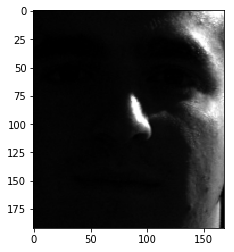

In [43]:
# read images like col
imagesOrig = v["faceData"]
imagesOrig = imagesOrig.astype("float32")
imagesOrig = imagesOrig.transpose()
print(imagesOrig.shape)
images = imagesOrig.reshape((2432,168, 192))
plt.imshow(images[1000].transpose(), cmap = "gray"); plt.show()

In [44]:
images.shape, imagesOrig.transpose().shape

((2432, 168, 192), (32256, 2432))

In [0]:
# split dataset
one_third = images.shape[0] /3 
index = int(2* one_third )
training = images[:index]
test = images[index:]

In [0]:
#https://lear.inrialpes.fr/pubs/2011/JDS11/jegou_searching_with_quantization.pdf
# http://mccormickml.com/2017/10/13/product-quantizer-tutorial-part-1/
# https://arxiv.org/pdf/1711.08589.pdf
import numpy as np
from scipy.cluster.vq import vq, kmeans2


class PQ(object):
    """Pure python implementation of Product Quantization (PQ) [Jegou11]_.
    For the indexing phase of database vectors,
    a `D`-dim input vector is divided into `M` `D`/`M`-dim sub-vectors.
    Each sub-vector is quantized into a small integer via `Ks` codewords.
    For the querying phase, given a new `D`-dim query vector, the distance beween the query
    and the database PQ-codes are efficiently approximated via Asymmetric Distance.
    All vectors must be np.ndarray with np.float32
    .. [Jegou11] H. Jegou et al., "Product Quantization for Nearest Neighbor Search", IEEE TPAMI 2011
    Args:
        M (int): The number of sub-space
        Ks (int): The number of codewords for each subspace
            (typically 256, so that each sub-vector is quantized
            into 256 bits = 1 byte = uint8)
        verbose (bool): Verbose flag
    Attributes:
        M (int): The number of sub-space
        Ks (int): The number of codewords for each subspace
        verbose (bool): Verbose flag
        code_dtype (object): dtype of PQ-code. Either np.uint{8, 16, 32}
        codewords (np.ndarray): shape=(M, Ks, Ds) with dtype=np.float32.
            codewords[m][ks] means ks-th codeword (Ds-dim) for m-th subspace
        Ds (int): The dim of each sub-vector, i.e., Ds=D/M
    """
    def __init__(self, M, Ks=256, verbose=True):
        assert 0 < Ks <= 2 ** 32
        self.M, self.Ks, self.verbose = M, Ks, verbose
        self.code_dtype = np.uint8 if Ks <= 2 ** 8 else (np.uint16 if Ks <= 2 ** 16 else np.uint32)
        self.codewords = None
        self.Ds = None

        if verbose:
            print("M: {}, Ks: {}, code_dtype: {}".format(M, Ks, self.code_dtype))

    def __eq__(self, other):
        if isinstance(other, PQ):
            return (self.M, self.Ks, self.verbose, self.code_dtype, self.Ds) == \
                   (other.M, other.Ks, other.verbose, other.code_dtype, other.Ds) and \
                   np.array_equal(self.codewords, other.codewords)
        else:
            return False

    def fit(self, vecs, iter=20, seed=123):
        """Given training vectors, run k-means for each sub-space and create
        codewords for each sub-space.
        This function should be run once first of all.
        Args:
            vecs (np.ndarray): Training vectors with shape=(N, D) and dtype=np.float32.
            iter (int): The number of iteration for k-means
            seed (int): The seed for random process
        Returns:
            object: self
        """
        assert vecs.dtype == np.float32
        assert vecs.ndim == 2
        N, D = vecs.shape
        assert self.Ks < N, "the number of training vector should be more than Ks"
        assert D % self.M == 0, "input dimension must be dividable by M"
        self.Ds = int(D / self.M)

        np.random.seed(seed)
        if self.verbose:
            print("iter: {}, seed: {}".format(iter, seed))

        # [m][ks][ds]: m-th subspace, ks-the codeword, ds-th dim
        self.codewords = np.zeros((self.M, self.Ks, self.Ds), dtype=np.float32)
        for m in range(self.M):
            if self.verbose:
                print("Training the subspace: {} / {}".format(m, self.M))
            vecs_sub = vecs[:, m * self.Ds : (m+1) * self.Ds]
            self.codewords[m], _ = kmeans2(vecs_sub, self.Ks, iter=iter, minit='points')

        return self

    def encode(self, vecs):
        """Encode input vectors into PQ-codes.
        Args:
            vecs (np.ndarray): Input vectors with shape=(N, D) and dtype=np.float32.
        Returns:
            np.ndarray: PQ codes with shape=(N, M) and dtype=self.code_dtype
        """
        assert vecs.dtype == np.float32
        assert vecs.ndim == 2
        N, D = vecs.shape
        assert D == self.Ds * self.M, "input dimension must be Ds * M"

        # codes[n][m] : code of n-th vec, m-th subspace
        codes = np.empty((N, self.M), dtype=self.code_dtype)
        for m in range(self.M):
            if self.verbose:
                print("Encoding the subspace: {} / {}".format(m, self.M))
            vecs_sub = vecs[:, m * self.Ds : (m+1) * self.Ds]
            codes[:, m], _ = vq(vecs_sub, self.codewords[m])

        return codes

    def decode(self, codes):
        """Given PQ-codes, reconstruct original D-dimensional vectors
        approximately by fetching the codewords.
        Args:
            codes (np.ndarray): PQ-cdoes with shape=(N, M) and dtype=self.code_dtype.
                Each row is a PQ-code
        Returns:
            np.ndarray: Reconstructed vectors with shape=(N, D) and dtype=np.float32
        """
        assert codes.ndim == 2
        N, M = codes.shape
        assert M == self.M
        assert codes.dtype == self.code_dtype

        vecs = np.empty((N, self.Ds * self.M), dtype=np.float32)
        for m in range(self.M):
            vecs[:, m * self.Ds : (m+1) * self.Ds] = self.codewords[m][codes[:, m], :]

        return vecs

    def dtable(self, query):
        """Compute a distance table for a query vector.
        The distances are computed by comparing each sub-vector of the query
        to the codewords for each sub-subspace.
        `dtable[m][ks]` contains the squared Euclidean distance between
        the `m`-th sub-vector of the query and the `ks`-th codeword
        for the `m`-th sub-space (`self.codewords[m][ks]`).
        Args:
            query (np.ndarray): Input vector with shape=(D, ) and dtype=np.float32
        Returns:
            nanopq.DistanceTable:
                Distance table. which contains
                dtable with shape=(M, Ks) and dtype=np.float32
        """
        assert query.dtype == np.float32
        assert query.ndim == 1, "input must be a single vector"
        D, = query.shape
        assert D == self.Ds * self.M, "input dimension must be Ds * M"

        # dtable[m] : distance between m-th subvec and m-th codewords (m-th subspace)
        # dtable[m][ks] : distance between m-th subvec and ks-th codeword of m-th codewords
        dtable = np.empty((self.M, self.Ks), dtype=np.float32)
        for m in range(self.M):
            query_sub = query[m * self.Ds : (m+1) * self.Ds]
            dtable[m, :] = np.linalg.norm(self.codewords[m] - query_sub, axis=1) ** 2

        return DistanceTable(dtable)


class DistanceTable(object):
    """Distance table from query to codeworkds.
    Given a query vector, a PQ/OPQ instance compute this DistanceTable class
    using :func:`PQ.dtable` or :func:`OPQ.dtable`.
    The Asymmetric Distance from query to each database codes can be computed
    by :func:`DistanceTable.adist`.
    Args:
        dtable (np.ndarray): Distance table with shape=(M, Ks) and dtype=np.float32
            computed by :func:`PQ.dtable` or :func:`OPQ.dtable`
    Attributes:
        dtable (np.ndarray): Distance table with shape=(M, Ks) and dtype=np.float32.
            Note that dtable[m][ks] contains the squared Euclidean distance between
            (1) m-th sub-vector of query and (2) ks-th codeword for m-th subspace.
    """
    def __init__(self, dtable):
        assert dtable.ndim == 2
        assert dtable.dtype == np.float32
        self.dtable = dtable

    def adist(self, codes):
        """Given PQ-codes, compute Asymmetric Distances between the query (self.dtable)
        and the PQ-codes.
        Args:
            codes (np.ndarray): PQ codes with shape=(N, M) and
                dtype=pq.code_dtype where pq is a pq instance that creates the codes
        Returns:
            np.ndarray: Asymmetric Distances with shape=(N, ) and dtype=np.float32
        """

        assert codes.ndim == 2
        N, M = codes.shape
        assert M == self.dtable.shape[0]

        # Fetch distance values using codes. The following codes are
        dists = np.sum(self.dtable[range(M), codes], axis=1)

        # The above line is equivalent to the followings:
        # dists = np.zeros((N, )).astype(np.float32)
        # for n in range(N):
        #     for m in range(M):
        #         dists[n] += self.dtable[m][codes[n][m]]

        return dists

In [47]:
num, m, n = training.shape
training = training.reshape((num, m*n))
# training = training.transpose()

num, m, n = test.shape
test = test.reshape((num, m*n))
# test = test.transpose()

test.shape, training.shape

((811, 32256), (1621, 32256))

In [48]:
pq = PQ(M=4, Ks=256, verbose=True)
pq.fit(vecs=training, iter=20, seed=123)

M: 4, Ks: 256, code_dtype: <class 'numpy.uint8'>
iter: 20, seed: 123
Training the subspace: 0 / 4
Training the subspace: 1 / 4
Training the subspace: 2 / 4
Training the subspace: 3 / 4


In [49]:
test_encoded = pq.encode(vecs=test)
training.shape, test.shape

Encoding the subspace: 0 / 4
Encoding the subspace: 1 / 4
Encoding the subspace: 2 / 4
Encoding the subspace: 3 / 4


((1621, 32256), (811, 32256))

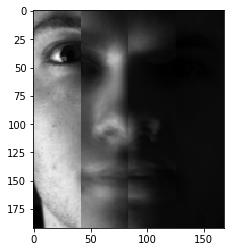

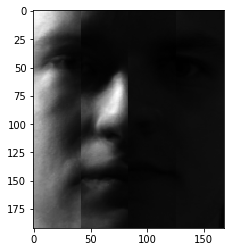

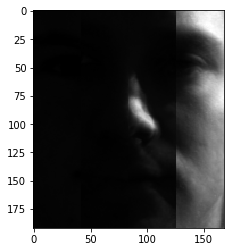

In [50]:
decompressed = pq.decode(codes=test_encoded)
decompressed.shape

images = decompressed.reshape((811,168, 192))
plt.imshow(images[4].transpose(), cmap = "gray"); plt.show()
plt.imshow(images[5].transpose(), cmap = "gray"); plt.show()
plt.imshow(images[-1].transpose(), cmap = "gray"); plt.show()

As seen above for non overlapping blocks after compressing our images with the Product opimaztion library written by a co-author of Jegu in the original paper of https://lear.inrialpes.fr/pubs/2011/JDS11/jegou_searching_with_quantization.pdf,  Matsui Yusuge I get quite interesting results.
It seems like every image has taken parts from other images of same kmeans cluster to be compressed.  Below we experiment with non-overlapping blocks


In [65]:
# training_blocks_non_overlapping = training.reshape((1621, 504, 64))
training_blocks_non_overlapping = training.reshape((816984, 64))
blocks = []
pq = PQ(M=4, Ks=256, verbose=True)
pq.fit(vecs=training_blocks_non_overlapping, iter=20, seed=123)

M: 4, Ks: 256, code_dtype: <class 'numpy.uint8'>
iter: 20, seed: 123
Training the subspace: 0 / 4
Training the subspace: 1 / 4
Training the subspace: 2 / 4


/usr/local/lib/python3.6/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


Training the subspace: 3 / 4


Encoding the subspace: 0 / 4
Encoding the subspace: 1 / 4
Encoding the subspace: 2 / 4
Encoding the subspace: 3 / 4


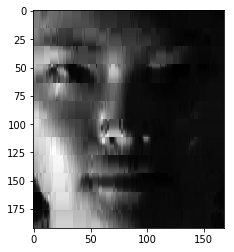

In [70]:
test_blocks_non_overlapping = test.reshape((408744, 64))
test_encoded = pq.encode(vecs=test_blocks_non_overlapping)
decompressed = pq.decode(codes=test_encoded)
images = decompressed.reshape((811,168, 192))
plt.imshow(images[4].transpose(), cmap = "gray"); plt.show()


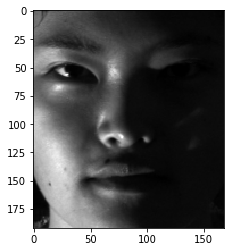

mse between PQ-ed image and original 67.35239856755355


In [76]:
def mse(imageA, imageB) -> float:
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err
testImg = test.reshape((811,168, 192))
plt.imshow(testImg[4].transpose(), cmap = "gray"); plt.show()


print("mse between PQ-ed image and original " + str(mse(testImg[4], images[4])))

In [0]:
# Experiment with oveelapping window

def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
  blocks = []
  for y in range(0, image.shape[0], stepSize):
    for x in range(0, image.shape[1], stepSize):
      blocks.append (np.array(image[y:y + windowSize, x:x + windowSize]))
  return np.array(blocks)

      
stepSize = 4
windowSize =8
# for img in training:
img = training[0]
image = img.reshape((168, 192))
overlapping_blocks = np.array(sliding_window(image, stepSize, windowSize))
  

# training_blocks_overlapping = for training
# training.shape, training_blocks.shape, test.shape

# img.reshape((168, 192))

In [119]:
overlapping_blocks = np.array(sliding_window(image, stepSize, windowSize))
overlapping_blocks.shape, overlapping_blocks[0].shape

((2016,), (8, 8))